<a href="https://www.kaggle.com/code/midnightranger/plates-classificator?scriptVersionId=104318532" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['plates', '__notebook_source__.ipynb', '__MACOSX']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 4035.94it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
#####################################################################
from torchvision import transforms, models

train_transforms = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir, train_transforms) for i in range(5)])
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(20, 160)

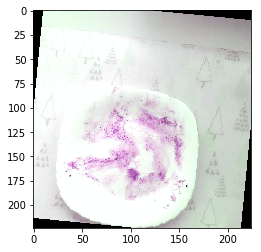

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

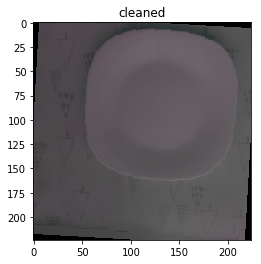

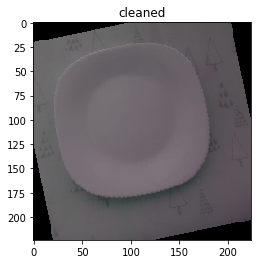

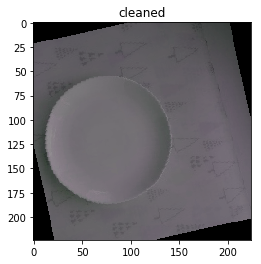

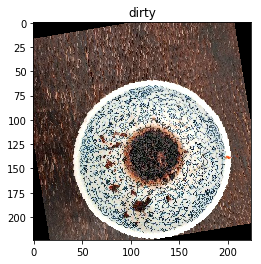

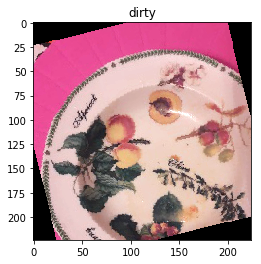

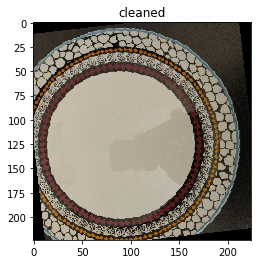

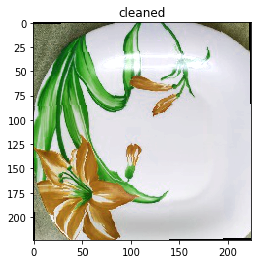

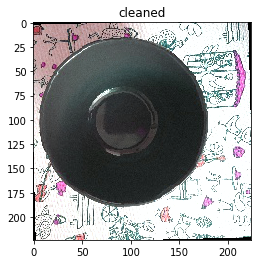

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet34(pretrained=True) #####################################################################

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) #####################################################################

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #####################################################################

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:08<00:00, 10145832.10it/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 20/20 [00:01<00:00, 10.01it/s]

train Loss: 0.6519 Acc: 0.6375



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.6416 Acc: 0.7500
Epoch 1/99:



100%|██████████| 20/20 [00:01<00:00,  9.33it/s]

train Loss: 0.5347 Acc: 0.7312



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

val Loss: 0.7951 Acc: 0.6250
Epoch 2/99:



100%|██████████| 20/20 [00:01<00:00, 11.93it/s]

train Loss: 0.4534 Acc: 0.7875



100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

val Loss: 0.7398 Acc: 0.5000
Epoch 3/99:



100%|██████████| 20/20 [00:01<00:00, 13.48it/s]

train Loss: 0.4382 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.7555 Acc: 0.5000
Epoch 4/99:



100%|██████████| 20/20 [00:01<00:00, 11.60it/s]

train Loss: 0.4384 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

val Loss: 0.8749 Acc: 0.6250
Epoch 5/99:



100%|██████████| 20/20 [00:01<00:00,  6.52it/s]

train Loss: 0.3216 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.7200 Acc: 0.3750
Epoch 6/99:



100%|██████████| 20/20 [00:01<00:00, 13.45it/s]

train Loss: 0.3883 Acc: 0.8375



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

val Loss: 0.8094 Acc: 0.5000
Epoch 7/99:



100%|██████████| 20/20 [00:01<00:00, 12.56it/s]

train Loss: 0.3510 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

val Loss: 0.8368 Acc: 0.6250
Epoch 8/99:



100%|██████████| 20/20 [00:01<00:00, 13.74it/s]

train Loss: 0.3268 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

val Loss: 0.8213 Acc: 0.5000
Epoch 9/99:



100%|██████████| 20/20 [00:01<00:00, 13.45it/s]

train Loss: 0.3696 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.7810 Acc: 0.6250
Epoch 10/99:



100%|██████████| 20/20 [00:02<00:00,  8.62it/s]

train Loss: 0.3129 Acc: 0.9187



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.8550 Acc: 0.6250
Epoch 11/99:



100%|██████████| 20/20 [00:01<00:00, 13.50it/s]

train Loss: 0.3430 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.8449 Acc: 0.6250
Epoch 12/99:



100%|██████████| 20/20 [00:01<00:00, 12.20it/s]

train Loss: 0.3501 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

val Loss: 0.7522 Acc: 0.6250
Epoch 13/99:



100%|██████████| 20/20 [00:01<00:00, 13.50it/s]

train Loss: 0.2994 Acc: 0.9187



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.7984 Acc: 0.6250
Epoch 14/99:



100%|██████████| 20/20 [00:01<00:00, 13.74it/s]

train Loss: 0.3296 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.8147 Acc: 0.6250
Epoch 15/99:



100%|██████████| 20/20 [00:02<00:00,  9.58it/s]

train Loss: 0.3240 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

val Loss: 0.7547 Acc: 0.6250
Epoch 16/99:



100%|██████████| 20/20 [00:02<00:00,  9.39it/s]

train Loss: 0.3011 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

val Loss: 0.7970 Acc: 0.5000
Epoch 17/99:



100%|██████████| 20/20 [00:02<00:00,  9.51it/s]

train Loss: 0.3147 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.7208 Acc: 0.6250
Epoch 18/99:



100%|██████████| 20/20 [00:02<00:00,  9.53it/s]

train Loss: 0.3068 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 0.7432 Acc: 0.6250
Epoch 19/99:



100%|██████████| 20/20 [00:02<00:00,  8.77it/s]

train Loss: 0.3266 Acc: 0.8875



100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

val Loss: 0.7615 Acc: 0.5000
Epoch 20/99:



100%|██████████| 20/20 [00:02<00:00,  9.33it/s]

train Loss: 0.3300 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.7618 Acc: 0.5000
Epoch 21/99:



100%|██████████| 20/20 [00:01<00:00,  3.96it/s]

train Loss: 0.3213 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.7762 Acc: 0.6250
Epoch 22/99:



100%|██████████| 20/20 [00:02<00:00,  5.57it/s]

train Loss: 0.3280 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.7523 Acc: 0.5000
Epoch 23/99:



100%|██████████| 20/20 [00:01<00:00,  3.96it/s]

train Loss: 0.4047 Acc: 0.8063



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 0.8346 Acc: 0.6250
Epoch 24/99:



100%|██████████| 20/20 [00:02<00:00,  8.42it/s]

train Loss: 0.3264 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.8590 Acc: 0.5000
Epoch 25/99:



100%|██████████| 20/20 [00:02<00:00,  9.51it/s]

train Loss: 0.2928 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.8144 Acc: 0.5000
Epoch 26/99:



100%|██████████| 20/20 [00:02<00:00,  9.45it/s]

train Loss: 0.3105 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.7541 Acc: 0.5000
Epoch 27/99:



100%|██████████| 20/20 [00:01<00:00,  3.89it/s]

train Loss: 0.3523 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.7814 Acc: 0.5000
Epoch 28/99:



100%|██████████| 20/20 [00:02<00:00,  8.00it/s]

train Loss: 0.3404 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

val Loss: 0.7626 Acc: 0.6250
Epoch 29/99:



100%|██████████| 20/20 [00:02<00:00,  9.57it/s]

train Loss: 0.2961 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.7330 Acc: 0.5000
Epoch 30/99:



100%|██████████| 20/20 [00:02<00:00,  7.06it/s]

train Loss: 0.3247 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

val Loss: 0.7849 Acc: 0.5000
Epoch 31/99:



100%|██████████| 20/20 [00:02<00:00,  9.54it/s]

train Loss: 0.3876 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.8520 Acc: 0.5000
Epoch 32/99:



100%|██████████| 20/20 [00:02<00:00,  8.46it/s]

train Loss: 0.3191 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.8086 Acc: 0.6250
Epoch 33/99:



100%|██████████| 20/20 [00:02<00:00,  9.42it/s]

train Loss: 0.3365 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

val Loss: 0.7570 Acc: 0.6250
Epoch 34/99:



100%|██████████| 20/20 [00:02<00:00,  9.15it/s]

train Loss: 0.3448 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

val Loss: 0.8057 Acc: 0.6250
Epoch 35/99:



100%|██████████| 20/20 [00:01<00:00,  6.30it/s]

train Loss: 0.3085 Acc: 0.8875



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.7598 Acc: 0.5000
Epoch 36/99:



100%|██████████| 20/20 [00:01<00:00, 11.69it/s]

train Loss: 0.3422 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.7756 Acc: 0.6250
Epoch 37/99:



100%|██████████| 20/20 [00:01<00:00, 12.68it/s]

train Loss: 0.3114 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.7891 Acc: 0.5000
Epoch 38/99:



100%|██████████| 20/20 [00:01<00:00, 12.45it/s]

train Loss: 0.2935 Acc: 0.9125



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

val Loss: 0.7900 Acc: 0.5000
Epoch 39/99:



100%|██████████| 20/20 [00:01<00:00,  6.44it/s]

train Loss: 0.2853 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.7999 Acc: 0.6250
Epoch 40/99:



100%|██████████| 20/20 [00:01<00:00, 13.51it/s]

train Loss: 0.3079 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

val Loss: 0.7247 Acc: 0.6250
Epoch 41/99:



100%|██████████| 20/20 [00:01<00:00, 11.71it/s]

train Loss: 0.3420 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.7952 Acc: 0.5000
Epoch 42/99:



100%|██████████| 20/20 [00:01<00:00, 11.38it/s]

train Loss: 0.3318 Acc: 0.8938



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

val Loss: 0.7773 Acc: 0.6250
Epoch 43/99:



100%|██████████| 20/20 [00:01<00:00, 13.47it/s]

train Loss: 0.3418 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.7718 Acc: 0.5000
Epoch 44/99:



100%|██████████| 20/20 [00:01<00:00, 13.49it/s]

train Loss: 0.3929 Acc: 0.8063



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

val Loss: 0.7560 Acc: 0.5000
Epoch 45/99:



100%|██████████| 20/20 [00:02<00:00,  9.29it/s]

train Loss: 0.3651 Acc: 0.8313



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.7633 Acc: 0.5000
Epoch 46/99:



100%|██████████| 20/20 [00:01<00:00, 13.46it/s]

train Loss: 0.3420 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.7481 Acc: 0.5000
Epoch 47/99:



100%|██████████| 20/20 [00:01<00:00, 13.01it/s]

train Loss: 0.3344 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.7824 Acc: 0.6250
Epoch 48/99:



100%|██████████| 20/20 [00:01<00:00, 13.30it/s]

train Loss: 0.3117 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 0.7901 Acc: 0.5000
Epoch 49/99:



100%|██████████| 20/20 [00:01<00:00,  6.62it/s]

train Loss: 0.3610 Acc: 0.8375



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

val Loss: 0.7732 Acc: 0.5000
Epoch 50/99:



100%|██████████| 20/20 [00:01<00:00, 13.58it/s]

train Loss: 0.3059 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

val Loss: 0.8300 Acc: 0.5000
Epoch 51/99:



100%|██████████| 20/20 [00:01<00:00, 12.19it/s]

train Loss: 0.3228 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.7940 Acc: 0.6250
Epoch 52/99:



100%|██████████| 20/20 [00:01<00:00, 13.52it/s]

train Loss: 0.3133 Acc: 0.8938



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.8313 Acc: 0.5000
Epoch 53/99:



100%|██████████| 20/20 [00:01<00:00, 11.51it/s]

train Loss: 0.3210 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

val Loss: 0.7982 Acc: 0.6250
Epoch 54/99:



100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

train Loss: 0.3206 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

val Loss: 0.8304 Acc: 0.6250
Epoch 55/99:



100%|██████████| 20/20 [00:01<00:00,  6.51it/s]

train Loss: 0.3141 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.7974 Acc: 0.6250
Epoch 56/99:



100%|██████████| 20/20 [00:01<00:00, 10.69it/s]

train Loss: 0.3170 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

val Loss: 0.8245 Acc: 0.5000
Epoch 57/99:



100%|██████████| 20/20 [00:01<00:00, 13.39it/s]

train Loss: 0.3583 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

val Loss: 0.8243 Acc: 0.6250
Epoch 58/99:



100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

train Loss: 0.3124 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

val Loss: 0.7597 Acc: 0.3750
Epoch 59/99:



100%|██████████| 20/20 [00:01<00:00, 11.47it/s]

train Loss: 0.3415 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.7973 Acc: 0.5000
Epoch 60/99:



100%|██████████| 20/20 [00:01<00:00, 13.42it/s]

train Loss: 0.2957 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.7981 Acc: 0.6250
Epoch 61/99:



100%|██████████| 20/20 [00:01<00:00, 13.42it/s]

train Loss: 0.3241 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

val Loss: 0.8065 Acc: 0.6250
Epoch 62/99:



100%|██████████| 20/20 [00:02<00:00,  8.96it/s]

train Loss: 0.3077 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.7729 Acc: 0.5000
Epoch 63/99:



100%|██████████| 20/20 [00:01<00:00, 13.47it/s]

train Loss: 0.2869 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.8167 Acc: 0.6250
Epoch 64/99:



100%|██████████| 20/20 [00:01<00:00, 11.80it/s]

train Loss: 0.3674 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8164 Acc: 0.5000
Epoch 65/99:



100%|██████████| 20/20 [00:01<00:00, 12.32it/s]

train Loss: 0.3026 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.8122 Acc: 0.5000
Epoch 66/99:



100%|██████████| 20/20 [00:01<00:00, 12.76it/s]

train Loss: 0.3682 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.7827 Acc: 0.5000
Epoch 67/99:



100%|██████████| 20/20 [00:01<00:00, 13.14it/s]

train Loss: 0.3197 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

val Loss: 0.8122 Acc: 0.6250
Epoch 68/99:



100%|██████████| 20/20 [00:01<00:00, 13.23it/s]

train Loss: 0.2936 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.8024 Acc: 0.6250
Epoch 69/99:



100%|██████████| 20/20 [00:01<00:00, 13.32it/s]

train Loss: 0.2990 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.8159 Acc: 0.6250
Epoch 70/99:



100%|██████████| 20/20 [00:01<00:00, 11.75it/s]

train Loss: 0.3190 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

val Loss: 0.8174 Acc: 0.5000
Epoch 71/99:



100%|██████████| 20/20 [00:01<00:00, 13.31it/s]

train Loss: 0.3097 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

val Loss: 0.7866 Acc: 0.5000
Epoch 72/99:



100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

train Loss: 0.3017 Acc: 0.8938



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.8205 Acc: 0.6250
Epoch 73/99:



100%|██████████| 20/20 [00:01<00:00, 13.31it/s]

train Loss: 0.3149 Acc: 0.8938



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.7856 Acc: 0.6250
Epoch 74/99:



100%|██████████| 20/20 [00:01<00:00,  6.32it/s]

train Loss: 0.3020 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.7674 Acc: 0.6250
Epoch 75/99:



100%|██████████| 20/20 [00:01<00:00, 13.15it/s]

train Loss: 0.3009 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

val Loss: 0.7871 Acc: 0.6250
Epoch 76/99:



100%|██████████| 20/20 [00:01<00:00, 11.10it/s]

train Loss: 0.3325 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.7773 Acc: 0.6250
Epoch 77/99:



100%|██████████| 20/20 [00:01<00:00, 12.03it/s]

train Loss: 0.3574 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

val Loss: 0.8215 Acc: 0.5000
Epoch 78/99:



100%|██████████| 20/20 [00:01<00:00, 13.34it/s]

train Loss: 0.3031 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

val Loss: 0.7833 Acc: 0.6250
Epoch 79/99:



100%|██████████| 20/20 [00:01<00:00, 10.02it/s]

train Loss: 0.3191 Acc: 0.8875



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

val Loss: 0.8001 Acc: 0.6250
Epoch 80/99:



100%|██████████| 20/20 [00:01<00:00, 13.27it/s]

train Loss: 0.3447 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.7882 Acc: 0.6250
Epoch 81/99:



100%|██████████| 20/20 [00:01<00:00, 11.79it/s]

train Loss: 0.3316 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

val Loss: 0.8047 Acc: 0.6250
Epoch 82/99:



100%|██████████| 20/20 [00:01<00:00, 13.05it/s]

train Loss: 0.3128 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.8056 Acc: 0.6250
Epoch 83/99:



100%|██████████| 20/20 [00:01<00:00, 13.25it/s]

train Loss: 0.3389 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

val Loss: 0.7853 Acc: 0.6250
Epoch 84/99:



100%|██████████| 20/20 [00:01<00:00, 13.48it/s]

train Loss: 0.3334 Acc: 0.8688



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.7724 Acc: 0.5000
Epoch 85/99:



100%|██████████| 20/20 [00:01<00:00, 13.48it/s]

train Loss: 0.3932 Acc: 0.8188



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.7195 Acc: 0.5000
Epoch 86/99:



100%|██████████| 20/20 [00:01<00:00, 13.33it/s]

train Loss: 0.3155 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.8182 Acc: 0.6250
Epoch 87/99:



100%|██████████| 20/20 [00:01<00:00, 10.35it/s]

train Loss: 0.3090 Acc: 0.8875



100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

val Loss: 0.7964 Acc: 0.5000
Epoch 88/99:



100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

train Loss: 0.3142 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.8117 Acc: 0.6250
Epoch 89/99:



100%|██████████| 20/20 [00:01<00:00, 13.29it/s]

train Loss: 0.3621 Acc: 0.8313



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.7907 Acc: 0.6250
Epoch 90/99:



100%|██████████| 20/20 [00:01<00:00, 13.33it/s]

train Loss: 0.3366 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.8210 Acc: 0.6250
Epoch 91/99:



100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

train Loss: 0.3356 Acc: 0.8813



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.8021 Acc: 0.6250
Epoch 92/99:



100%|██████████| 20/20 [00:01<00:00, 12.44it/s]

train Loss: 0.3134 Acc: 0.8875



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

val Loss: 0.7844 Acc: 0.6250
Epoch 93/99:



100%|██████████| 20/20 [00:01<00:00, 11.78it/s]

train Loss: 0.3258 Acc: 0.8938



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.7570 Acc: 0.5000
Epoch 94/99:



100%|██████████| 20/20 [00:01<00:00,  8.99it/s]

train Loss: 0.2895 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.8119 Acc: 0.5000
Epoch 95/99:



100%|██████████| 20/20 [00:01<00:00, 13.34it/s]

train Loss: 0.3294 Acc: 0.8375



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

val Loss: 0.8150 Acc: 0.6250
Epoch 96/99:



100%|██████████| 20/20 [00:02<00:00,  8.72it/s]

train Loss: 0.3663 Acc: 0.8875



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

val Loss: 0.7428 Acc: 0.5000
Epoch 97/99:



100%|██████████| 20/20 [00:01<00:00, 12.04it/s]

train Loss: 0.3387 Acc: 0.8562



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 0.8782 Acc: 0.6250
Epoch 98/99:



100%|██████████| 20/20 [00:01<00:00, 11.62it/s]

train Loss: 0.3197 Acc: 0.8625



100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

val Loss: 0.8589 Acc: 0.6250
Epoch 99/99:



100%|██████████| 20/20 [00:01<00:00, 13.41it/s]

train Loss: 0.3098 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.8175 Acc: 0.6250


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:04<00:00, 23.13it/s]


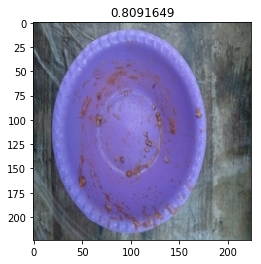

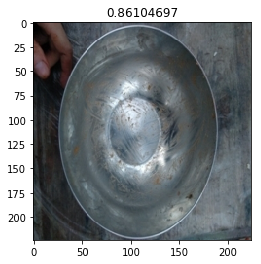

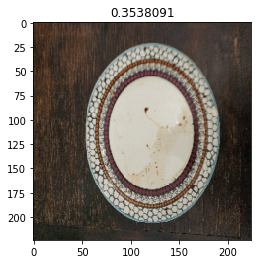

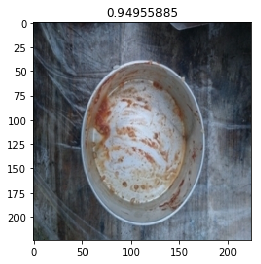

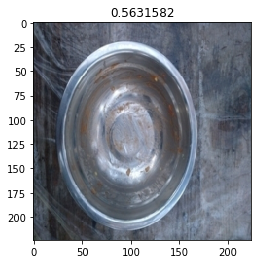

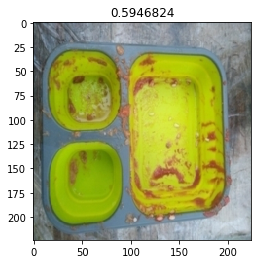

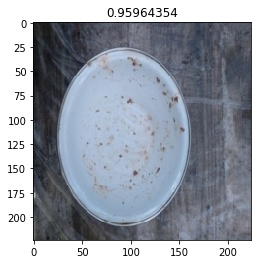

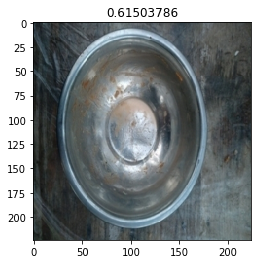

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test